In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
conti_stocks_df = pd.read_csv(r"D:\streamlit_learn\streamlit_learn\conti.csv")
conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04 00:00:00+02:00,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07 00:00:00+02:00,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08 00:00:00+02:00,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09 00:00:00+02:00,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10 00:00:00+02:00,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [3]:
# Convert with timezone awareness
conti_stocks_df['Date'] = pd.to_datetime(conti_stocks_df['Date'], utc=True)

# Remove timestamp:
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_localize(None)

# Now you can floor to day
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.floor('D')

conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-03,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-06,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-07,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-08,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-09,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [4]:
conti_stocks_df_new = conti_stocks_df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].copy()

c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


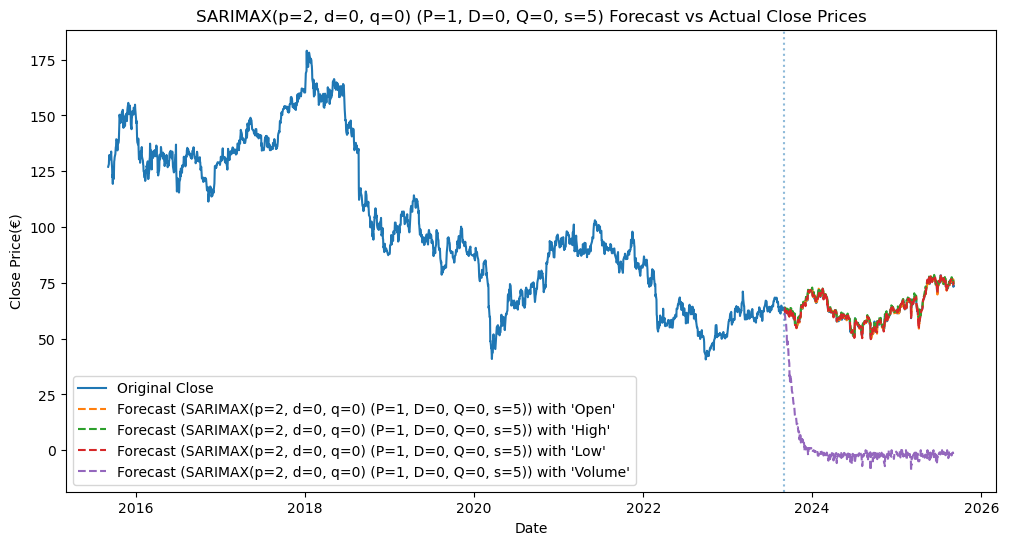

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_size = int(len(conti_stocks_df_new) * 0.8)
train, test = conti_stocks_df_new.iloc[:train_size], conti_stocks_df_new.iloc[train_size:]

# Fit ARIMA(0,0,0) model on Close data (no differencing)
model_open = SARIMAX(train['Close'], exog=train[['Open']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 5))
model_fit_open = model_open.fit()
model_high = SARIMAX(train['Close'], exog=train[['High']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 5))
model_fit_high = model_high.fit()
model_low = SARIMAX(train['Close'], exog=train[['Low']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 5))
model_fit_low = model_low.fit()
model_volume = SARIMAX(train['Close'], exog=train[['Volume']], order=(2, 0, 0), seasonal_order=(1, 0, 0, 5))
model_fit_volume = model_volume.fit()


# Forecast for test length
forecast_open = model_fit_open.forecast(steps=len(test), exog=test[['Open']])
forecast_high = model_fit_open.forecast(steps=len(test), exog=test[['High']])
forecast_low = model_fit_low.forecast(steps=len(test), exog=test[['Low']])
forecast_volume = model_fit_volume.forecast(steps=len(test), exog=test[['Volume']])


# Convert forecast into a Series aligned with test dates
forecast_series_open = pd.Series(forecast_open.values, index=test['Date'])
forecast_series_high = pd.Series(forecast_high.values, index=test['Date'])
forecast_series_low = pd.Series(forecast_low.values, index=test['Date'])
forecast_series_volume = pd.Series(forecast_volume.values, index=test['Date'])

# Plot original Close vs Forecast
plt.figure(figsize=(12,6))
plt.plot(conti_stocks_df_new['Date'], conti_stocks_df_new['Close'], label="Original Close")
plt.plot(forecast_series_open.index, forecast_series_open, label="Forecast (SARIMAX(p=2, d=0, q=0) (P=1, D=0, Q=0, s=5)) with 'Open'", linestyle="--")
plt.plot(forecast_series_high.index, forecast_series_high, label="Forecast (SARIMAX(p=2, d=0, q=0) (P=1, D=0, Q=0, s=5)) with 'High'", linestyle="--")
plt.plot(forecast_series_low.index, forecast_series_low, label="Forecast (SARIMAX(p=2, d=0, q=0) (P=1, D=0, Q=0, s=5)) with 'Low'", linestyle="--")
plt.plot(forecast_series_volume.index, forecast_series_volume, label="Forecast (SARIMAX(p=2, d=0, q=0) (P=1, D=0, Q=0, s=5)) with 'Volume'", linestyle="--")


# Mark training end
plt.axvline(conti_stocks_df_new["Date"].iloc[train_size-1], alpha=0.5, linestyle=":")

plt.xlabel("Date")
plt.ylabel("Close Price(€)")
plt.title("SARIMAX(p=2, d=0, q=0) (P=1, D=0, Q=0, s=5) Forecast vs Actual Close Prices")
plt.legend()
plt.show()

In [6]:
# Forecast for training (in-sample predictions)
train_pred = model_fit_open.predict(start=0, end=len(train)-1, exog=train[['Open']])

# Forecast for test set
test_forecast = model_fit_open.forecast(steps=len(test), exog=test[['Open']])

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(actual, predicted, dataset_name=""):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE : {smape:.2f}%")
    print(f"R^2 score : {r2:.2f}")
    

# Training metrics
calculate_metrics(train['Close'], train_pred, "Training")

# Testing metrics
calculate_metrics(test['Close'], test_forecast, "Testing")


Performance Metrics for Training:
MAE  : 1.2310
MSE  : 2.9045
RMSE : 1.7042
MAPE : 1.33%
sMAPE : 1.33%
R^2 score : 1.00

Performance Metrics for Testing:
MAE  : 0.6925
MSE  : 0.9439
RMSE : 0.9715
MAPE : 1.10%
sMAPE : 1.10%
R^2 score : 0.98
